# アンサンブル＋最頻値  
学習データは時系列データ  
学習はランダムのデータを使う  
テストはvalidationのデータを使う  
最頻値を使ったスムージングも適応したやつ。  
次元数が多すぎて過学習したのか？  
v4で次元数削減を試してみる

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
from scipy.stats import mode

In [2]:
fold = "../train_random_20000/"
# .npyファイルからデータをロード
x = np.load(f'{fold}x.npy')
label = np.load(f"{fold}label.npy")

# データの形状を表示
print("Shape of the loaded x data:", x.shape)
print("Shape of the loaded label data:", label.shape)

Shape of the loaded x data: (20000, 500)
Shape of the loaded label data: (20000,)


In [3]:
print(pd.Series(label).value_counts())

7.0    3261
5.0    3193
6.0    2924
1.0    2507
2.0    2491
4.0    2422
8.0    2349
3.0     853
Name: count, dtype: int64


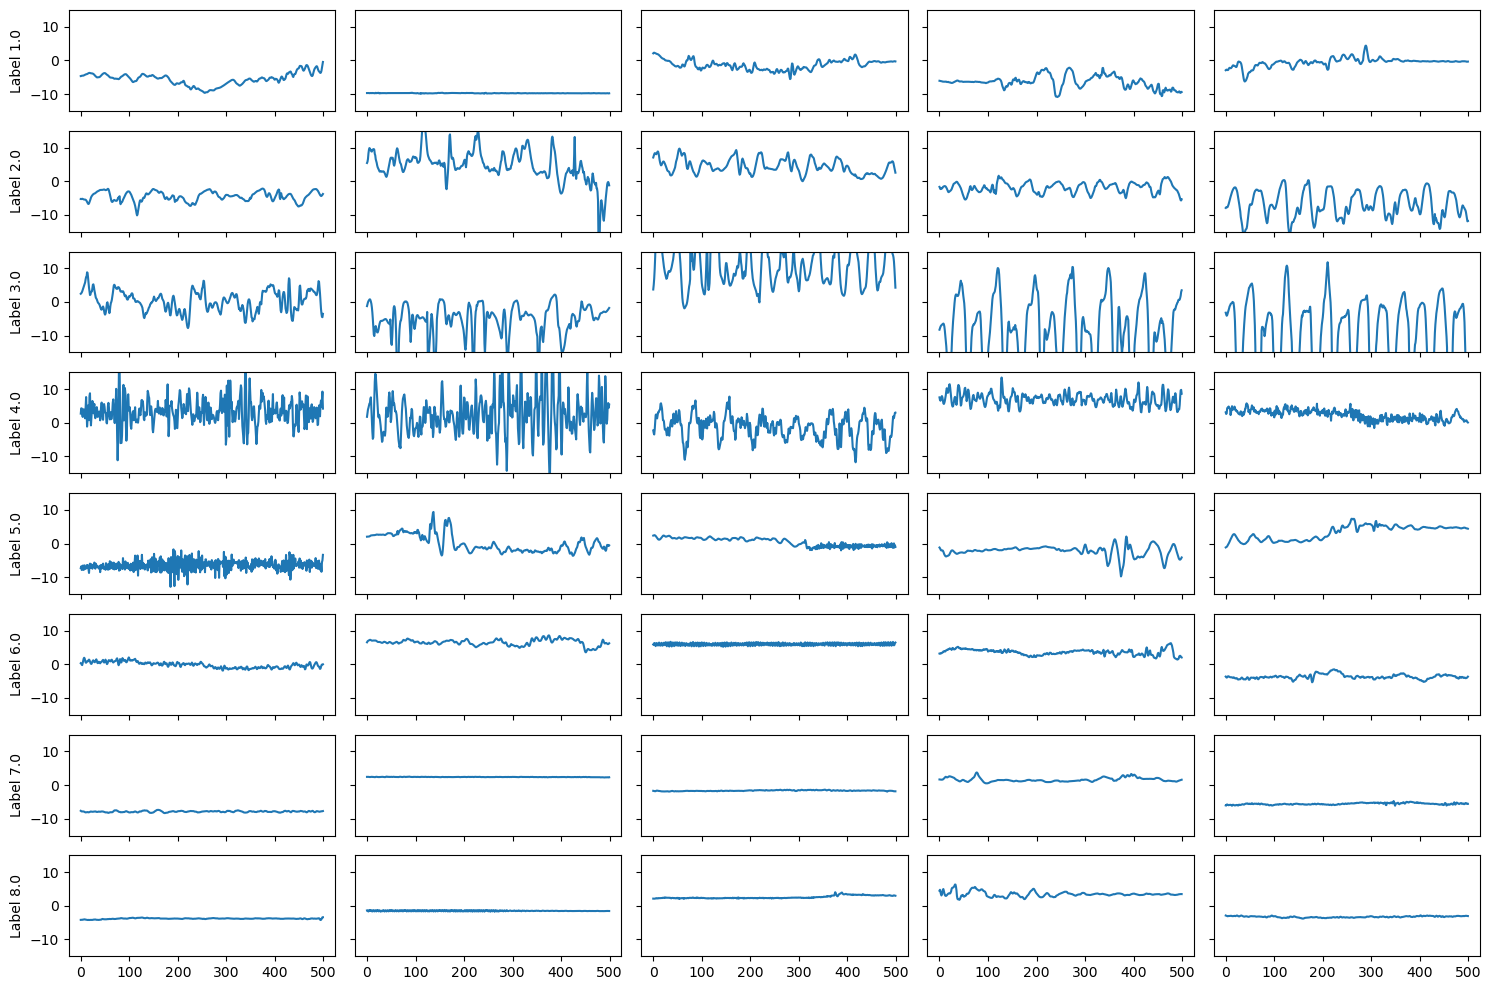

In [4]:
# 一意なラベルを取得
unqY = np.unique(label)

# 各アノテーションについて5つのグラフを描画
NPLOTS = 5
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(15, 10))

# 各ラベルについてのプロット
for y, row in zip(unqY, axs):
    indices = np.where(label == y)[0]
    
    # サンプリングインデックス数がNPLOTS未満の場合の対応
    if len(indices) < NPLOTS:
        sampled_indices = indices
    else:
        sampled_indices = np.random.choice(indices, size=NPLOTS, replace=False)
    
    row[0].set_ylabel(f'Label {y}')
    for x_data, ax in zip(x[sampled_indices], row):
        ax.plot(x_data)
        ax.set_ylim(-15, 15)

fig.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, label, train_size=16000, shuffle=False)

In [5]:
train_x = x.copy()
train_y = label.copy()

In [6]:
fold = "../validation_0toLast/"
test_x = np.load(f"{fold}x.npy")
test_y = np.load(f"{fold}label.npy")

In [7]:
# 分割後のデータの形状を表示
print("Shape of train_x:", train_x.shape)
print("Shape of test_x:", test_x.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_x: (20000, 500)
Shape of test_x: (28789, 500)
Shape of train_y: (20000,)
Shape of test_y: (28789,)


In [8]:
print(np.unique(train_y))
print(np.unique(test_y))

[1. 2. 3. 4. 5. 6. 7. 8.]
[1. 2. 3. 4. 5. 6. 7. 8.]


In [64]:
clf = BalancedRandomForestClassifier(
    n_estimators=500,
    replacement=True,
    sampling_strategy='not majority',
    oob_score=True,
    n_jobs=6,
    random_state=42,
    verbose=1
)
clf.fit(train_x,train_y) # 訓練データを使ってまずランダムフォレストを学習している。

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   38.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  1.7min finished


BalancedRandomForestClassifier(n_estimators=500, n_jobs=6, oob_score=True,
                               random_state=42, replacement=True,
                               sampling_strategy='not majority', verbose=1)

以下はこれからのために取っておく

In [ ]:
Y_test_pred = clf.predict(test_x) # 学習器の性能をみる テストデータで
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred, zero_division=0))

# This will be the training set
Y_in_train = clf.oob_decision_function_.astype('float32') # OOBデータを用いて予測。結果をY_in_trainに入れている。
# This will be the test set
Y_in_test = clf.predict_proba(test_x).astype('float32') # クラス所属確率の予測も入っている。Y_test_predとは違って他のクラスへの所属確率も出力している点に留意

In [24]:
print(test_y)
print(Y_test_pred)

[3. 3. 3. ... 2. 2. 2.]
[1. 1. 3. ... 2. 2. 6.]


In [65]:
Y_test_pred = clf.predict(test_x)
#Y_test_pred = clf.predict(train_x)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred))
#print('Out of sample:\n', metrics.classification_report(train_y, Y_test_pred))


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:    1.7s finished



Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.23      0.40      0.30      5967
         2.0       0.80      0.41      0.54      5225
         3.0       0.52      0.62      0.56       555
         4.0       0.13      0.02      0.03      2407
         5.0       0.22      0.05      0.08      4095
         6.0       0.02      0.00      0.01      1836
         7.0       0.20      0.61      0.30      4362
         8.0       0.46      0.00      0.01      4342

    accuracy                           0.27     28789
   macro avg       0.32      0.26      0.23     28789
weighted avg       0.35      0.27      0.23     28789



In [66]:
import scipy.stats as stats

def mode(alist):
    m,c = stats.mode(alist) # mは最頻値、cは最頻値の出現回数
    m,c = m.item(), c.item()
    if c == 1:
        return alist[len(alist)//2] # つまり最頻値が決められない場合真ん中の値をとるということ
    return m

def rolling_mode(y, window_size=1500): # ラベルy
    y_dtype_origin = y.dtype
    y = pd.Series(y, dtype='category')

    y_code_smooth = y.cat.codes.rolling(window_size).apply(mode,raw=True)

    #NaNを元の値で埋める
    y_code_smooth = y_code_smooth.fillna(y.cat.codes)

    # intに変換
    y_code_smooth = y_code_smooth.astype('int')
    
    y_smooth = pd.Categorical.from_codes(y_code_smooth, dtype=y.dtype)
    y_smooth = np.asarray(y_smooth, dtype=y_dtype_origin)
    return y_smooth

In [67]:
Y_test_pred_smooth = []
Y_test_pred_smooth.append(rolling_mode(Y_test_pred,window_size=6))

In [68]:
Y_test_pred_smooth = np.concatenate(Y_test_pred_smooth)

In [69]:
print(Y_test_pred_smooth)

[1. 1. 3. ... 1. 2. 2.]


これはアンサンブル学習と最頻値を使ったものの比較

In [70]:
print('\nClassifier performance -- mode smoothing')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred))
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred_smooth))


Classifier performance -- mode smoothing
Out of sample:
               precision    recall  f1-score   support

         1.0       0.23      0.40      0.30      5967
         2.0       0.80      0.41      0.54      5225
         3.0       0.52      0.62      0.56       555
         4.0       0.13      0.02      0.03      2407
         5.0       0.22      0.05      0.08      4095
         6.0       0.02      0.00      0.01      1836
         7.0       0.20      0.61      0.30      4362
         8.0       0.46      0.00      0.01      4342

    accuracy                           0.27     28789
   macro avg       0.32      0.26      0.23     28789
weighted avg       0.35      0.27      0.23     28789

Out of sample:
               precision    recall  f1-score   support

         1.0       0.22      0.43      0.29      5967
         2.0       0.84      0.41      0.55      5225
         3.0       0.61      0.64      0.62       555
         4.0       0.35      0.01      0.02      2407
    

In [37]:
print(pd.Series(train_y).value_counts())

7.0    3261
5.0    3193
6.0    2924
1.0    2507
2.0    2491
4.0    2422
8.0    2349
3.0     853
Name: count, dtype: int64


一旦ロジスティックしてみる

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [62]:
clf_LR = LogisticRegression( #　ロジスティック回帰モデルの設定とパイプラインの定義
    max_iter=1000,
    multi_class='multinomial',
    random_state=42)
scaler = StandardScaler()
pipe = make_pipeline(scaler, clf_LR) # パイプラインを定義して
pipe.fit(train_x, train_y) # ここでパイプラインを学習

Y_test_pred_LR = pipe.predict(test_x) # ここで予測

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
print("hmmなしの予測値")
print(metrics.classification_report(test_y, Y_test_pred_LR))

hmmなしの予測値
              precision    recall  f1-score   support

         1.0       0.23      0.00      0.01      5967
         2.0       0.50      0.05      0.09      5225
         3.0       0.60      0.07      0.13       555
         4.0       0.18      0.03      0.06      2407
         5.0       0.13      0.09      0.11      4095
         6.0       0.08      0.02      0.04      1836
         7.0       0.17      0.91      0.28      4362
         8.0       0.01      0.00      0.00      4342

    accuracy                           0.17     28789
   macro avg       0.24      0.15      0.09     28789
weighted avg       0.22      0.17      0.08     28789

